# 1. Import all the distributions

In [1]:
%pylab inline --no-import-all
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get distribs and filter bad ones
import distributions

all_distributions_dict = dict([(name, cls) for name, cls in distributions.__dict__.items() if isinstance(cls, type)])
all_distributions_list = [(cls) for name, cls in distributions.__dict__.items() if isinstance(cls, type)]

ok_distributions_list=[]
problems=[]
for i, cls in enumerate(all_distributions_list):
    #print(cls)
    try:
        dist = cls()
        N_test = 100000
        #print('will try to generate for %s' %(cls.__name__))
        if dist.pdf(dist.x_min + .3*(dist.x_max-dist.x_min)) < 1E-3:
            print("may have a problem")
            continue
            
        rvs = dist.rvs(N_test)
        if np.abs(np.mean(rvs) - dist.mean()) > 5*np.std(rvs)/np.sqrt(N_test):
            print("means don't match for %s: %f vs. %f" %(cls.__name__, 
                                                          np.mean(rvs), dist.mean()))
            continue
            
        elif np.abs(np.std(rvs) - dist.std()) > 5*np.std(rvs)/np.sqrt(np.sqrt(1.*N_test)):
            print("std devs. don't match for %s: %f vs. %f" %(cls.__name__, 
                                                          np.std(rvs), dist.std()))
            continue
        elif np.abs(np.std(rvs) - dist.std()) / dist.std() > 0.1:
            print("std devs. don't match for %s: %f vs. %f" %(cls.__name__, 
                                                          np.std(rvs), dist.std()))
            continue
        
        elif np.sum(dist.pdf(np.linspace(dist.x_min,dist.x_max,100))<0) > 0:
            print("pdf was negative in some places")
            continue                    

        else:
            # print("%s passes tests, adding it" %(cls.__name__))
            ok_distributions_list.append(cls)
    except:
        print("%s has errors, does't work" %(cls.__name__))
        continue

print "\nOK distributions: {0}".format([i.__name__ for i in ok_distributions_list])

std devs. don't match for Dist_vag273: 0.144454 vs. 0.288675
std devs. don't match for Dist_pc1727: 0.845196 vs. 1.000000
std devs. don't match for Dist_rdr335: 0.398187 vs. 0.100000
means don't match for Dist_my1462: -1.920250 vs. 3.000000
std devs. don't match for Dist_mh3908: 28.892109 vs. 38.000000
std devs. don't match for Dist_ptf223: 2.851560 vs. 2.150000
means don't match for Dist_jeg535: -3.293163 vs. 0.072000
std devs. don't match for Dist_sar653_1: 0.500563 vs. 0.626657
means don't match for Dist_jgc375: 2130.456453 vs. 2130.937950
std devs. don't match for Dist_dl3185: 0.774920 vs. 0.632456
std devs. don't match for Dist_vag273_1: 0.144104 vs. 0.288675
may have a problem

OK distributions: ['Dist_sm6376', 'Dist_ry643', 'Dist_yr595', 'Dist_psa251_2', 'Dist_kw1621', 'Dist_nj18', 'Dist_hk1764', 'Dist_yz2668', 'Dist_psa251', 'Dist_ejk483', 'Dist_ih646', 'Dist_kc90_2', 'Dist_kc90_3', 'Dist_vag273_2', 'Dist_msc565', 'Dist_jn1348', 'Dist_kjm538', 'Dist_recast', 'Dist_saw533', 'Dis

# 2. Run convolutions

In [3]:
# Split functions to provide more generality
def random_convolution(list_of_distributions, N, size):
    q = np.zeros(size)
    var_q = 0.
    mean_q = 0.

    for dist_class in np.random.choice(list_of_distributions,N):
        dist = dist_class()
        
        print 'Using: %s ' % (dist_class.__name__)
        
        q      += dist.rvs(size)
        var_q  += dist.std()**2
        mean_q += dist.mean()

    std_q = np.sqrt( var_q )
    
    return q, mean_q, std_q

def graph_convolution(dist, mean_dist, std_dist):
    counts, bins, patches = plt.hist(dist ,bins=50, normed=True, alpha=.2)
    plt.plot(bins, stats.norm.pdf(bins, loc=mean_dist, scale=std_dist), lw=2, c='r')
    
    return counts, bins

Select number of samples to run

In [4]:
N_SAMPLES = 100000

Using: Dist_kjm538 
Using: Dist_ih646 
Using: Dist_yz2668 
Using: Dist_ih646 
Using: Dist_jsg549 
Using: Dist_psa251 
Using: Dist_ih646 
Using: Dist_kw1621 
Using: Dist_hk1764 
Using: Dist_ih646 
Using: Dist_sm6376 
Using: Dist_hk1764 
Using: Dist_kjm538 
Using: Dist_nj18 
Using: Dist_recast 


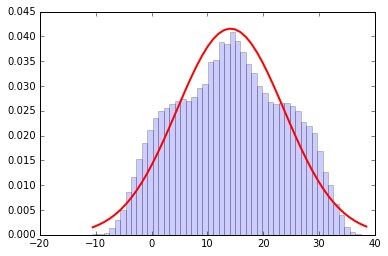

In [5]:
# 15 iterations
y, mu_y, s_y = random_convolution(ok_distributions_list, 15, N_SAMPLES)
y_counts, y_bins = graph_convolution(y, mu_y, s_y)

# 3. Generate norm predictions from bins

In [6]:
def fetch_bin_centers(bins):
    rights  = bins[1:]
    lefts   = bins[:-1]

    centers = (rights + lefts) / 2
    return centers

In [7]:
y_centers = fetch_bin_centers(y_bins)
y_centers

array([-10.05530973,  -9.07459672,  -8.09388372,  -7.11317071,
        -6.13245771,  -5.15174471,  -4.1710317 ,  -3.1903187 ,
        -2.20960569,  -1.22889269,  -0.24817968,   0.73253332,
         1.71324633,   2.69395933,   3.67467234,   4.65538534,
         5.63609835,   6.61681135,   7.59752436,   8.57823736,
         9.55895037,  10.53966337,  11.52037638,  12.50108938,
        13.48180239,  14.46251539,  15.4432284 ,  16.4239414 ,
        17.40465441,  18.38536741,  19.36608041,  20.34679342,
        21.32750642,  22.30821943,  23.28893243,  24.26964544,
        25.25035844,  26.23107145,  27.21178445,  28.19249746,
        29.17321046,  30.15392347,  31.13463647,  32.11534948,
        33.09606248,  34.07677549,  35.05748849,  36.0382015 ,
        37.0189145 ,  37.99962751])

Check if the area is ~1, a feature of the Gaussian normal distribution (or any distribution)

In [8]:
np.sum(y_counts * (y_bins[1] - y_bins[0]))

1.0

In [9]:
prediction = stats.norm.pdf(y_centers)*N_SAMPLES*(y_bins[1] - y_bins[0])
prediction

array([  4.33367675e-018,   5.13741463e-014,   2.32771154e-010,
         4.03097530e-007,   2.66801061e-004,   6.74934152e-002,
         6.52576895e+000,   2.41156193e+002,   3.40613284e+003,
         1.83874363e+004,   3.79382432e+004,   2.99178024e+004,
         9.01734321e+003,   1.03878088e+003,   4.57367952e+001,
         7.69668921e-001,   4.95038080e-003,   1.21694150e-005,
         1.14339749e-008,   4.10602133e-012,   5.63561875e-016,
         2.95636769e-020,   5.92750222e-025,   4.54235885e-030,
         1.33041641e-035,   1.48932741e-041,   6.37219721e-048,
         1.04204067e-054,   6.51293239e-062,   1.55583991e-069,
         1.42052761e-077,   4.95713664e-086,   6.61162993e-095,
         3.37040912e-104,   6.56679020e-114,   4.89012656e-124,
         1.39182135e-134,   1.51406083e-145,   6.29505593e-157,
         1.00035074e-168,   6.07577161e-181,   1.41041533e-193,
         1.25137949e-206,   4.24353205e-220,   5.49999603e-234,
         2.72454322e-248,   5.15847661e-

# 4. Chi-Square Test

In [10]:
chisq_obs, p_val = stats.chisquare(y_counts, prediction)
chisq_obs, p_val

(2.3816216223746511e+300, 0.0)

In [11]:
stats.chi2.sf(chisq_obs, y_counts.size - 1)

0.0

At the ```a = 0.01 level```, the p-value above is greatly less than ```a```, suggesting very strong evidence that the convolutions fail to reject the hypothesis of the Central Limit Theorem.